# Model Train (Time-based split & Full retrain)

## Import Library

In [14]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

## 데이터 로드 및 통합

In [ ]:
# # 전체 파일 목록을 정렬하여 가져오기
# data_files = sorted(glob.glob("../data/time-based-split/preprocessed/train/*.csv"))

# num_files_to_load = 1 # 학습할 파일 갯수 설정
# df_list = []

# for f in data_files[:num_files_to_load]:
#     print(f"Loading file: {f}")
#     df = pd.read_csv(f)
#     df_list.append(df)

# train_df = pd.concat(df_list, ignore_index=True)
# val_df = pd.read_csv("../data/time-based-split/preprocessed/9_val.csv")
# test_df = pd.read_csv("../data/time-based-split/preprocessed/10_test.csv")

# print(f"train_df.shape: {train_df.shape}")
# print(f"val_df.shape: {val_df.shape}")
# print(f"test_df.shape: {test_df.shape}")

Loading file: ../data/time-based-split/preprocessed/train\1_train.csv
train_df.shape: (283074, 44)
val_df.shape: (283074, 44)
test_df.shape: (283077, 44)


In [15]:
# 1. 파일 목록 가져오기 (train: 1~8, val: 9, test: 10)
train_files = sorted(glob.glob("../data/time-based-split/preprocessed/train/*.csv"))
val_file = "../data/time-based-split/preprocessed/9_val.csv"
test_file = "../data/time-based-split/preprocessed/10_test.csv"

# 2. validation, test 고정 로드
val_df = pd.read_csv(val_file)
test_df = pd.read_csv(test_file)

print(f"val_df.shape: {val_df.shape}")
print(f"test_df.shape: {test_df.shape}")

val_df.shape: (283074, 44)
test_df.shape: (283077, 44)


## Feature/Label 분리

In [16]:
FEATURE_COLS = [col for col in val_df.columns if col not in ['Label_binary']]
TARGET_COL = 'Label_binary'

## 모델 학습 반복 (train 파일 개수 늘리면서)

In [ ]:
val_scores = []
test_scores = []
num_train_files = len(train_files) # Train 파일 개수

num_train_files

8

In [18]:
for n in range(1, num_train_files + 1):
    # 1. n개의 train 파일 합치기
    df_list = []
    for f in train_files[:n]:
        print(f"[INFO] Loading file: {f}")
        df = pd.read_csv(f)
        df_list.append(df)
    train_df = pd.concat(df_list, ignore_index=True)
    print(f"train_df.shape: {train_df.shape}")

    # 2. Feature/Label 분리
    X_train = train_df[FEATURE_COLS]
    y_train = train_df[TARGET_COL]
    X_val = val_df[FEATURE_COLS]
    y_val = val_df[TARGET_COL]
    X_test = test_df[FEATURE_COLS]
    y_test = test_df[TARGET_COL]

    # 3. 모델 학습 (고정 파라미터)
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)

    # 4. 검증 성능 측정 (validation)
    y_val_pred = clf.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_auc = roc_auc_score(y_val, clf.predict_proba(X_val)[:,1])
    val_scores.append({'n_files': n, 'val_acc': val_acc, 'val_auc': val_auc})

    # 5. 최종 test 성능(오염 방지 위해 한 번만)
    y_test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    test_scores.append({'n_files': n, 'test_acc': test_acc, 'test_auc': test_auc})

    print(f"[RESULT] Train files: {n}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}, Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

[INFO] Loading file: ../data/time-based-split/preprocessed/train\1_train.csv
train_df.shape: (283074, 44)
[RESULT] Train files: 1, Val Acc: 0.5537, Val AUC: 0.7289, Test Acc: 0.9675, Test AUC: 0.5503
[INFO] Loading file: ../data/time-based-split/preprocessed/train\1_train.csv
[INFO] Loading file: ../data/time-based-split/preprocessed/train\2_train.csv
train_df.shape: (566148, 44)
[RESULT] Train files: 2, Val Acc: 0.3532, Val AUC: 0.6906, Test Acc: 0.9675, Test AUC: 0.8731
[INFO] Loading file: ../data/time-based-split/preprocessed/train\1_train.csv
[INFO] Loading file: ../data/time-based-split/preprocessed/train\2_train.csv
[INFO] Loading file: ../data/time-based-split/preprocessed/train\3_train.csv
train_df.shape: (849222, 44)
[RESULT] Train files: 3, Val Acc: 0.3532, Val AUC: 0.7999, Test Acc: 0.9675, Test AUC: 0.7356
[INFO] Loading file: ../data/time-based-split/preprocessed/train\1_train.csv
[INFO] Loading file: ../data/time-based-split/preprocessed/train\2_train.csv
[INFO] Loading 

## 결과 DataFrame으로 정리

In [19]:
val_scores_df = pd.DataFrame(val_scores)
test_scores_df = pd.DataFrame(test_scores)

## 성능 곡선 시각화

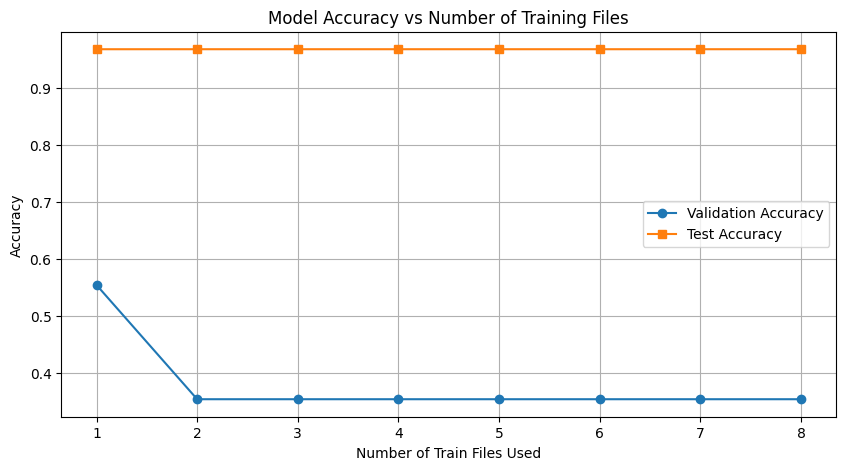

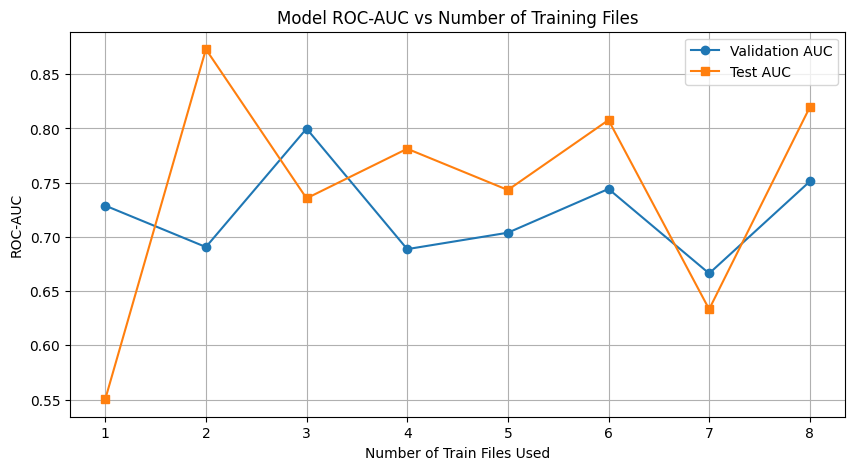

In [20]:
plt.figure(figsize=(10,5))
plt.plot(val_scores_df['n_files'], val_scores_df['val_acc'], marker='o', label='Validation Accuracy')
plt.plot(test_scores_df['n_files'], test_scores_df['test_acc'], marker='s', label='Test Accuracy')
plt.xlabel("Number of Train Files Used")
plt.ylabel("Accuracy")
plt.title("Model Accuracy vs Number of Training Files")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(val_scores_df['n_files'], val_scores_df['val_auc'], marker='o', label='Validation AUC')
plt.plot(test_scores_df['n_files'], test_scores_df['test_auc'], marker='s', label='Test AUC')
plt.xlabel("Number of Train Files Used")
plt.ylabel("ROC-AUC")
plt.title("Model ROC-AUC vs Number of Training Files")
plt.legend()
plt.grid()
plt.show()

## 각 단계별 상세 리포트 저장 (선택)

In [21]:
for n in [1, num_train_files]:
    print(f"\n[DETAIL REPORT] Train files: {n}")
    df_list = []
    for f in train_files[:n]:
        df = pd.read_csv(f)
        df_list.append(df)
    train_df = pd.concat(df_list, ignore_index=True)
    X_train = train_df[FEATURE_COLS]
    y_train = train_df[TARGET_COL]
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    print("[Validation]")
    print(classification_report(y_val, clf.predict(X_val)))
    print("[Test]")
    print(classification_report(y_test, clf.predict(X_test)))


[DETAIL REPORT] Train files: 1
[Validation]
              precision    recall  f1-score   support

           0       0.44      1.00      0.61     99974
           1       1.00      0.31      0.47    183100

    accuracy                           0.55    283074
   macro avg       0.72      0.66      0.54    283074
weighted avg       0.80      0.55      0.52    283074

[Test]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    273891
           1       0.00      0.00      0.00      9186

    accuracy                           0.97    283077
   macro avg       0.48      0.50      0.49    283077
weighted avg       0.94      0.97      0.95    283077


[DETAIL REPORT] Train files: 8
[Validation]


c:\Users\Admin\Desktop\security-engineer\Python\waap-ml-research\02-adaptive-traffic-classifier\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\Desktop\security-engineer\Python\waap-ml-research\02-adaptive-traffic-classifier\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\Desktop\security-engineer\Python\waap-ml-research\02-adaptive-traffic-classifier\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined

              precision    recall  f1-score   support

           0       0.35      1.00      0.52     99974
           1       0.00      0.00      0.00    183100

    accuracy                           0.35    283074
   macro avg       0.18      0.50      0.26    283074
weighted avg       0.12      0.35      0.18    283074

[Test]


c:\Users\Admin\Desktop\security-engineer\Python\waap-ml-research\02-adaptive-traffic-classifier\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\Desktop\security-engineer\Python\waap-ml-research\02-adaptive-traffic-classifier\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98    273891
           1       0.00      0.00      0.00      9186

    accuracy                           0.97    283077
   macro avg       0.48      0.50      0.49    283077
weighted avg       0.94      0.97      0.95    283077



c:\Users\Admin\Desktop\security-engineer\Python\waap-ml-research\02-adaptive-traffic-classifier\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
